In [272]:
import os
import time

import cv2

import sys
import bisect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.signal as signal
import scipy.interpolate as interpolate
from scipy import ndimage as nd

from skimage import transform

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import TheilSenRegressor
from sklearn.preprocessing import MinMaxScaler

import isx

In [2]:
def count_nans(indat):
    #
    # returns the number of NaN values in indat
    # 
    
    return np.isnan(indat).sum()

def events_to_raster(event_times,timing,smooth_win=0):
    #
    # returns raster and length vector of event_times, optionally smoothed with gaussian of smooth_win number of pnts
    #
    # timing is <class 'isx.core.Timing'> from EventSet
    #
    # Example usage: offs,amps = events_1.get_cell_data(0)
    # [rast,tvect] = events_to_raster(offs,events_1.timing,0)
    # plot tvect vs rast
    #
    
    samp_vect = [i for i in range(timing.num_samples)]
    event_times_samps = event_times / timing.period.to_usecs()
    raster = np.zeros_like(samp_vect)
    if len(event_times) == 0:
        raster = [np.nan for i in raster]        
        return[raster,samp_vect]
    else:    
        raster[event_times_samps.astype(int)] = 1
    
        if smooth_win > 0:
            win = signal.gaussian(int(smooth_win)*10,smooth_win)
            raster_sm = np.convolve(raster,win,mode='same')
            raster = raster_sm
        
        return [raster,samp_vect]

def rasters_from_eventset(eventset,sm_win=0):
    #
    # returns numcell X sample matrix of rasters derived from eventset
    #
    # optionally smooths rasters with gaussian window with std deviation = sm_win samples
    #
    
    offs,amps = eventset.get_cell_data(0)
    raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
    outmtx = np.zeros([len(raster),eventset.num_cells])
    for cellnum in range(eventset.num_cells):
        offs,amps = eventset.get_cell_data(cellnum)
        raster,raster_x = events_to_raster(offs,eventset.timing,sm_win)
        outmtx[:,cellnum] = raster
    
    return outmtx
 
def traces_from_cellset(cellset,nrm=0):
    #
    # returns numcells x max(tstamps) matrix of traces from cellset
    # centers (mean subtracts) each trace if nrm==1
    #
    
    tracelen = 0
    for i in range(cellset.num_cells): # find length of traces for initialization:
        if len(cellset.get_cell_trace_data(0)) > tracelen:
            tracelen = len(cellset.get_cell_trace_data(0))
            break
    outmtx = np.zeros([tracelen,cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        if nrm == 1 and sum(abs(cellset.get_cell_trace_data(i)))>0:
            outmtx[:,i] = cellset.get_cell_trace_data(i) - np.nanmean(cellset.get_cell_trace_data(i))
        else:    
            outmtx[:,i] = cellset.get_cell_trace_data(i)
    return outmtx

def images_from_cellset(cellset):
    #
    # returns numcells x max(tstamps) matrix of images from cellset
    #
    img = cellset.get_cell_image_data(0)
    
    outmtx = np.zeros([img.shape[0],img.shape[1],cellset.num_cells]) # init output
    for i in range(cellset.num_cells): # populate output with traces from cellsets:
        outmtx[:,:,i] = cellset.get_cell_image_data(i)
    return outmtx


def remove_nan_rows(inmtx_list):
    #
    # Detects rows with missing data points (NaNs) in each matrix in inmtx_list. Removes rows from all elements
    # of inmtx_list
    #
    
    nanrows = []
    outlist = []
    for mtx in inmtx_list:
        livecols = np.where(np.all(np.isnan(mtx),axis=0)==False)[0] # find columns that contain data
        thenanrows = np.where(np.any(np.isnan(mtx[:,livecols]),axis=1))[0] # find rows with NaNs
        nanrows.append(thenanrows)
    del_these_rows = [i for lst in nanrows for i in lst] # flattens lists in nanrows
    
    for mtx in inmtx_list:
        outmtx = np.delete(mtx,del_these_rows,axis=0)
        #outlist.append(np.delete(mtx,del_these_rows,axis=0))
        outlist.append(outmtx)
    
    return outlist

def build_trace_volume(cellset_list):
    #
    # assembles [p,l,c] matrix of traces from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # removes dropped/cropped frames from all cellsets' data
    # removes additional rows with missing data from all cellsets' data
    #
    # if traces are not equal length, crops ends to minimum length
    #
    # returns trace_matrix
    # 
    
    remove_frames = np.array([],dtype=int)
    tracemtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        remove_frames = np.append(remove_frames,cellset.timing.dropped)
        remove_frames = np.append(remove_frames,cellset.timing.cropped)
        tracemtx_list.append(traces_from_cellset(cellset,nrm=1))
    
    clean_list = []
    for m in tracemtx_list:
        outmtx = np.delete(m,remove_frames.flatten().astype(int),axis=0)
        clean_list.append(outmtx)    
    
    clean_list_nonan = remove_nan_rows(clean_list)
    npnts = min([len(i) for i in clean_list_nonan])
    out_list = [i[0:npnts,:] for i in clean_list_nonan]
    trace_vol = np.stack(out_list,axis=0)
    
    return trace_vol

def build_img_volume(cellset_list):
    #
    # assembles [p,x,y,c] matrix of images from list of LR cellsets. p is number of planes/cellsets, l is data
    # length, c is number of cells.
    #
    # returns image matrix
    #

    mtx_list = []
    for l in cellset_list:
        cellset = isx.CellSet.read(l)
        mtx_list.append(images_from_cellset(cellset))
    
    img_vol = np.stack(mtx_list,axis=0)
    
    return img_vol

def build_raster_volume(eventset_list,sm_win=0):
    #
    # assembles [p,x,c] matrix of rasters from list of LR cellsets. p is number of planes/cellsets, x is data
    # length, c is number of cells.
    #
    # optionally smooths rasters with gaussian with std = sm_win samples 
    #
    # returns raster matrix
    #

    mtx_list = []
    for l in eventset_list:
        eventset = isx.EventSet.read(l)
        mtx_list.append(rasters_from_eventset(eventset,sm_win))
    
    rast_vol = np.stack(mtx_list,axis=0)
    
    return rast_vol
    
def find_LR_planes(inmtx):
    #
    # detects plane boundaries in Longitudinally registered matrix 
    #
    # returns list of start and stop points for each plane, e.g for 3 planes: [[0:100],[101:200],[201:300]]
    #
    
    outpnts = []
    start_p = 0
    for p in range(inmtx.shape[0]): # each plane
        if p == inmtx.shape[0]-1:
            stop_p = inmtx.shape[2]
        #elif len(np.nonzero(np.isnan(inmtx[p,0,start_p:]))):
        elif np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1]:
            print(p)
            #print(np.isnan(inmtx[p,0,start_p:]))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:]))))
            print(np.shape(np.nonzero(np.isnan(inmtx[p,0,start_p:])))[1])
            stop_p = np.min(np.nonzero(np.isnan(inmtx[p,0,start_p:])))+start_p
        else:
            stop_p = inmtx.shape[2]
        outpnts.append([start_p,stop_p-1])
        start_p = stop_p
        
    return outpnts

def corr_dist_1d_volume(inmtx,bkpnts):
#
# returns distrubution of trace x trace correlations for signals within a plane
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of endpoints that separate imaging planes, e.g. if bkpnts = [100,200,500],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#
# to call this function on first plane in matrix, use corr_dist_1d_volume(mtx[0:1,:,:])
# to call this function on second plane in matrix, use corr_dist_1d_volume(mtx[1:2,:,:]) etc
#
    corrlist = []
    
    pnt_i = 0
    startpnt = 0
    for plane in inmtx:
        subplane = plane[:,startpnt:bkpnts[pnt_i]]
        #print(np.shape(subplane),end='')
        corrmtx = (np.corrcoef(subplane,rowvar=False))
        corrs = corrmtx[np.triu_indices(corrmtx.shape[0],k=1)]
        corrlist.append(corrs)
        
        startpnt = bkpnts[pnt_i]+1
        pnt_i += 1
        
    #return np.concatenate(corrlist)
    return corrlist

def corr_dist_z_volume(inmtx,bkpnts):
#
# returns list of distrubutions of trace x trace correlations for distinct xy signals between planes.
# also returns list of indices of planes analyzed to serve as a lookup table
#
# inmtx is matrix of union cellsets with dimensions [num_planes,data_length,num_signals]
# bkpnts is array of start-endpoints that separate imaging planes, e.g. if bkpnts = [[0,100],[101,200],[201,500]],
# units IDed on plane 1 are inmtx[0,:,0:100], units IDed on plane 2 are inmtx[1,:,101:200], etc
# Bkpnts should be same length of np.shape(inmtx)[0]
#

    corrlist = []
    corrmtxlist = []
    
    plane_list = list(range(np.shape(inmtx)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    for f in plane_combos:
        subplane1 = inmtx[f[0],:,bkpnts[f[0]][0]:bkpnts[f[0]][1]]
        subplane2 = inmtx[f[1],:,bkpnts[f[1]][0]:bkpnts[f[1]][1]]
        mergeplane = np.concatenate([subplane1,subplane2],axis=1)
        
        corrmtx = (np.corrcoef(mergeplane,rowvar=False))        
        corrs = corrmtx[0:bkpnts[f[0]][1]-bkpnts[f[0]][0],bkpnts[f[0]][1]-bkpnts[f[0]][0]+1:len(corrmtx)]
        corrmtxlist.append(corrs)
        corrlist.append(np.ravel(corrs))
        
    return [corrlist,corrmtxlist,plane_combos]

def aligned_z_corrs(data_volume,threshs = []):
    #
    # returns distribution of z-correlations in data_volume
    # Optionally makes retain/reject decision for each element based on threshs
    #
    
    plane_list = list(range(np.shape(data_volume)[0]))
    plane_combos = list(itl.combinations(plane_list,2))
    
    datacorrs = []
    
    if len(threshs) > 0:
        decision_array = np.zeros([trace_volume.shape[2],1])
        decision_planes = [[] for i in decision_array]
        splitcorrs = []
    
    for i in range(data_volume.shape[2]): # each cell
        combo_i = 0
        for f in plane_combos: # each pairwise plane set
            #corrthresh = corr_threshs[f[0],f[1]]
            if len(threshs) > 0:
                corrthresh = corr_threshs[combo_i]
                combo_i += 1
                #print(corrthresh)
            trace1 = data_volume[f[0],:,i]
            trace2 = data_volume[f[1],:,i]
        
            if np.isnan(trace1).sum() == 0 and np.isnan(trace2).sum() == 0: # if cell has signal on multiple planes then split/merge:
                thecorr = np.corrcoef(trace1,trace2)[0][1]
                datacorrs.append(thecorr)
                if len(threshs) > 0:
                    if thecorr < corrthresh: # split cells
                        decision_array[i] = 1
                        decision_planes[i].append(f)
                        splitcorrs.append(round(thecorr,2))

    if len(threshs) > 0:
        return [datacorrs,decision_array,decision_planes,splitcorrs]
    else:
        return datacorrs
    
def write_1d_cellset(fn,trace_data,img_data,cell_names,spacing,timing):
    #
    # writes .isxd cellset file to filename = fn
    # trace_data is [n,c] shaped matrix of activity traces. n = trace length, c = number of cells
    # img_data is [x,y,c] shaped matrix of cell images. x and y = image dimensions, c = number of cells
    #
    # cell_names is list of strings to name each cell. If this is empty, cells are named sequentially.
    # 
    # spacing and timing are given by data movies and describe image size and activity (trace) sampling info
    #
    # overwrites existing cellsets with same names without warning
    #
    
    if os.path.exists(fn) is False:
        out_cellset = isx.CellSet.write(fn,timing,spacing)
    elif os.path.exists(fn) is True:
        os.remove(fn)
        out_cellset = isx.CellSet.write(fn,timing,spacing)
        
    for i in range(trace_data.shape[1]): # each cell        
        if len(cell_names) == 0:
            c_name = 'C{}'.format(i)
            
        else:
            c_name = cell_names[i]
        out_cellset.set_cell_data(i,img_data[:,:,i].astype(np.float32),trace_data[:,i].astype(np.float32),c_name)
    
    out_cellset.flush()
    
def sensitivity_precision(data_volume,winsize = 5):
    #
    # returns sensitivity and precision calcs for each element n [:,:,n] in data_volume
    #
    # data_volume[,n,:] are event traces over time (e.g. event trains / rasters)
    # data_volume[n,:,:] are reference and test sets
    #
    # winsize is integer size of window around events
    #
    
    conv_vect = np.ones((1,winsize))[0]
    
    sens = []
    prec = []
    
    for i in range(data_volume.shape[2]): # each element [:,:,i]
        ref_trace = data_volume[0,:,i]
        test_trace = data_volume[1,:,i]
        if np.isnan(ref_trace).sum() == 0 and np.isnan(test_trace).sum() == 0: # if cell has signal on both planes:
            # detected (test) events:
            sm_rast_det = np.convolve(test_trace,conv_vect,mode='same')
            sm_rast_det[sm_rast_det > 0] = 1
            det_pos_pnts = np.nonzero(sm_rast_det)[0] # points around test events
            det_neg = [i for i in range(len(ref_trace)) if i not in det_pos_pnts] # points around test negatives
            
            true_pos = (sum(ref_trace[det_pos_pnts]))
            false_pos = max([sum(test_trace) - true_pos, 0])
            false_neg = sum(ref_trace[det_neg])
            #true_neg = len([i for i in ref_neg if i in det_neg])
            
            prec.append(true_pos / (true_pos + false_pos)) # precision: fraction of correctly detected events among all detected events
            sens.append(true_pos / (true_pos + false_neg)) # sensitivity: fraction of events detected
            

    return [sens,prec] 
    
def event_detection_cnmfe(cellset, snr_thresh = 1, peak_dist = 0.25, peak_width = 0.4):
    #
    # Applies scipy.signal.findpeaks() to identify events in CNMF-E or PCA-ICA cellset traces and writes isx.Eventset
    #
    # Designed to detect events in cnmfe cellsets but also applicable to PCA-ICA cellsets
    #
    # Computes threshold for each trace as [snr_thresh * (abs(median_abs_deviation / median) * median_abs_deviation)] 
    #
    # 
    #
    
    ed_file = isx.make_output_file_path(cellset.file_path, os.path.dirname(cellset.file_path), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    cellnames = [cellset.get_cell_name(i) for i in range(cellset.num_cells)]    
    ed_set = isx.EventSet.write(ed_file, cellset.timing, cellnames)
    
    cellset_fs = round((1 / (cellset.timing.period.to_usecs() * 1e-6) ),3)
    #print(cellset_fs)
    pdist = int(peak_dist * cellset_fs)
    pwidth = int(peak_width * cellset_fs)
    
    for i in range(cellset.num_cells):
        the_trace = cellset.get_cell_trace_data(i)

        thresh_mult = snr_thresh * abs(stats.median_absolute_deviation(the_trace) / np.median(the_trace))
        peak_thresh = thresh_mult * abs(stats.median_absolute_deviation(the_trace))        
        
        peaks = signal.find_peaks(the_trace, peak_thresh, distance= pdist, width= pwidth)[0]
        ed_set.set_cell_data(i, 1e6*(peaks/cellset_fs), the_trace[peaks])
    ed_set.flush()
    return ed_set.file_path
    
    
def cellset_qc(cellset_fn, eventset_fn, filters):
    #
    # applies conditions to accept/reject cells in cellset based on eventset
    #
    # filters format = [('SNR', '>', 5), ('Event Rate', '>', 0.0015), ('# Comps', '=', 1)]
    #
    
    cellset = isx.CellSet.read(cellset_fn,read_only=False)
    if os.path.isfile(eventset_fn):
        eventset = isx.EventSet.read(eventset_fn)
    else: 
        event_detection_cnmfe(cellset)
        eventset = isx.EventSet.read(eventset_fn)
    metric_fn = isx.make_output_file_path(cellset_fn, os.path.dirname(cellset_fn), 'METRICS')
    if os.path.isfile(metric_fn):
        os.remove(metric_fn)
    isx.cell_metrics(cellset_fn, eventset_fn, metric_fn)
    metrics_df = pd.read_csv(metric_fn)
    metrics_df.columns = [i.lower() for i in metrics_df.columns]
    
    cell_rej = []
    tmp_rej = []
    for i in filters:
        if i[0].lower() in metrics_df.columns: # identify cells that fail criterion:
            tmp_rej = []
            tmp_rej.append(metrics_df.loc[metrics_df[i[0].lower()] <= float(i[2])].index)
            #print('Checking cells {}...'.format(i[0]))
            cell_rej += tmp_rej
        else: 
            print('{} is not a valid metric.'.format(i[0]))

    os.remove(metric_fn)
    
    out_list = sorted(list(set([i for j in cell_rej for i in j])))
    accept_list = [i for i in range(cellset.num_cells) if i not in out_list]
    
    # modify cellsets:
    for i in out_list:
        cellset.set_cell_status(i,'rejected')
    for i in accept_list:
        cellset.set_cell_status(i,'accepted')    
    
    
    return out_list
    
    
def twoaxis(axname,lwidth=1.5):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)

In [3]:
def apply_butterworth(sig,cutoff,fs,filt_order,filt_type):
    #
    # applies zero-phase digital butterworth filter to data in sig
    # if sig is a matrix, data in its columns are filtered
    #
    # cutoff is filter's critical frequency in Hz, or n=2 tuple of freqs for bandpass filters
    # fs is sampling rate
    # filt_order is integer filter order
    # filt_type is 'lowpass','highpass', 'bandpass', or 'bandstop' 
    # 
    # returns filtered signal 
    #
    
    nyq = 0.5 * fs
    norm_cutoff =cutoff/nyq
    b,a = signal.butter(filt_order,norm_cutoff,btype=filt_type,analog=False)
    
    if sig.ndim > 1:
        filt_sig = signal.filtfilt(b,a,sig,axis=1)
    elif sig.ndim == 1:
        filt_sig = signal.filtfilt(b,a,sig)
    else:
        filt_sig = []
    
    return filt_sig

def median_filter_matrix(inmtx,winsize=3):
    #
    # median filters each column of matrix with kernal width = winsize
    #
    # returns filtered matrix
    #
    
    filtmtx = np.zeros_like(inmtx)
    
    for i in range(inmtx.shape[0]):
        filtmtx[i] = signal.medfilt(inmtx[i],winsize)
    return filtmtx

def otsu(x):
    # returns threshold estimated via Otsu's method
    # x needs to be 1-d list
    nbins = 500
    logx = np.log(x)
    logx = np.asarray([i for i in logx if np.isfinite(i)])
    
    minim = min(logx)
    maxim = max(logx)
    logx = (logx-minim)/(maxim-minim)
    
    xhist = np.histogram(logx, bins=nbins)
    xbins = xhist[1]
    xbins = xbins[1:]
    xcounts = xhist[0] / sum(xhist[0])

    maximum = 0
    thresh = 0
    
    for t in range(len(xcounts)):
        w0 = sum(xcounts[:t])
        w1 = sum(xcounts) - w0
        if w0 == 0 or w1 == 0:
            #print('continuing...')
            continue
        mu0 = sum(xbins[:t]*xcounts[:t]) / w0
        mu1 = sum(xbins[t:]*xcounts[t:]) / w1
        sigB = w0 * w1 * ((mu0 - mu1) * (mu0 - mu1))
        if sigB >= maximum:
            maximum = sigB
            thresh = xbins[t]
    
    th = thresh*(maxim-minim) + minim
    th = np.exp(th)
    #th = np.power(10,th)
    thresh = th

    return thresh


def register_signals(ref_time,in_dat,in_time):
    #
    # Direct alignment of signals that were sampled at diffrent rates
    # resamples in_dat to len(ref_time) by aligning timestamps in ref_time with timestamps in in_time
    # in_time is vector of timestamps for data in in_dat
    #
    # len(ref_time) < len(in_time)
    #
    #
    
    resamp_dat = np.zeros_like(ref_time)

    for t in range(len(ref_time)):
        dat = in_dat[bisect.bisect(in_time,ref_time[t])-1]
        resamp_dat[t] = dat
    return resamp_dat
    
def segment(x,thresh):
    # returns onsets & offset indices of impulses that exceed thresh in vector x
    xsub = x - thresh
    xdiff = (xsub[:-1]*xsub[1:]) < 0
    edges = np.where(xdiff == 1) # indices at onsets/offsets
    edges = list(edges[0])
    
    x[0:5] = 0
    
    if np.mean(np.diff(x[edges[0]-2:edges[0]+2])) < 0: # delete first impulse if offset
        print('first impulse is offset')
        edges.pop(0)
    if np.mean(np.diff(x[edges[-1]-2:edges[-1]+2])) > 0: # delete last impulse if onset
        print('last impulse is onset')
        edges.pop(-1)
    onsets = edges[0::2]
    offsets = edges[1::2]
    
    if len(onsets) > len(offsets):
        onsets.pop(-1)
    
    return [onsets,offsets]

def extractsegments(x,onsets,offsets,win):
    # returns list of slices from x[onsets[i]-win:offsets[i]+win]
    
    win = int(win)
    if onsets[0] - win < 1 or offsets[-1] > len(x):
        print('Edge Syllable')
        return []
    else:
        segs = [x[onsets[i]-win : offsets[i]+win] for i in range(len(onsets))]
        return segs
    
def filtersegments(segs,minlen,maxlen):
    # deletes elements of segs with maxlen < len() < minlen
    return [i for i in segs if len(i) > minlen and len(i) < maxlen]
    
def twoaxis(axname,lwidth=2):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)
    
# functions for object detection:

def subtract_img_background(input_img):
    #
    # Uses pixel dilation to adaptively filter nonuniform background from objects in input_img
    #
    # input image is NxM  matrix of pixel intensities 
    #
    # returns filtered image.
    #
    # Adapted from skimage 'Filtering regional maxima'. Requires : 
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.ndimage import gaussian_filter
    # from skimage.filters import threshold_otsu
    # #from skimage import img_as_float
    # from skimage.morphology import reconstruction
    #
    #
    img = img_as_float(input_img)
    img_g = gaussian_filter(img,1)

    h = threshold_otsu(img_g)

    seed = img_g - h
    mask = img_g

    dilated = reconstruction(seed,mask,method='dilation')

    return img_g-dilated

def norm_image(in_img):
    #
    # returns in_img normalized to [0-255]
    #
    #
    
    i_min = np.min(in_img)
    i_max = np.max(in_img)
    
    norm_img = 255 * ((in_img + abs(i_min) / i_max))
    
    return norm_img

def estimate_num_cells(in_img):
    #
    # Estimates number of gaussian-like blobs in in_img using laplacian of gaussians (LoG)
    #
    # 
    # in_img is NxM matrix of pixel intensities
    # in_img is probably maximum or other projection of motion corrected or df/f movie
    #
    # requires skimage.feature.blob_log()
    #
    # returns N x 3 matrix, N=num_blobs, out[0] = y coordinates, out[1] = x coordinates, out[2] = blob radius 
    #
    
    # log_params:
    min_sigma = 2
    max_sigma = 20
    num_sigma = int((max_sigma-min_sigma))
    threshold = 1
    overlap =0.1
    
    img_background_subtract = subtract_img_background(in_img)
    img_norm = norm_image(img_background_subtract)
    objs = blob_log(img_norm,min_sigma = min_sigma,max_sigma=max_sigma,num_sigma=num_sigma,threshold=threshold,overlap=overlap)
    
    return objs


In [4]:
def cellset_data_volumes(cs_file):
    #
    # reads cellset specified by cs_file and returns:
    # [trace_mtx, raster_mtx, raster_mad_mtx]
    #
    # trace_mtx is [n,m] matrix of m-cells n-sample calcium signals 
    # raster_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with event_detection_cnmfe()
    # raster_mas_mtx is [n,m] matrix of m-cells n-sample calcium events (0-1) deteted with isx.event_detection()
    # 
    # returns accepted/undecided cells only
    #
    
    # read cellset:
    cellset = isx.CellSet.read(cs_file)

    # event detection:
    ed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')
    if os.path.isfile(ed_file):
        os.remove(ed_file)
    event_detection_cnmfe(cellset, snr_thresh = 2, peak_dist = 0.3, peak_width = 0.2)

    # isx (MAD) event detection:
    isxed_file = isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')
    if os.path.isfile(isxed_file):
        os.remove(isxed_file)
    isx.event_detection(cs_file, isxed_file, event_time_ref='maximum')


    # build trace, raster, peak data volumes:
    trace_volume = build_trace_volume([cs_file])
    raster_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'ED')], sm_win=0)
    raster_isx_volume = build_raster_volume([isx.make_output_file_path(cs_file, os.path.dirname(cs_file), 'isxED')], sm_win=0)
    #peak_volume = (raster_volume*trace_volume) # rasters with scalar event sizes
    #peak_isx_volume = (raster_isx_volume*trace_volume)
    #ref_volume = np.copy(trace_volume)
    #ref_volume[10:,0] = signal.medfilt(ref_volume[:-10,0],7)

    # get length of recording:
    #max_t = (isx.Duration.to_usecs(cellset.timing.period)*1e-6) * cellset.timing.num_samples

    # create mask for excluding rejected cells:
    cell_mask = np.ones((cellset.num_cells))
    #print(cellset.num_cells)
    for i in range(cellset.num_cells):
        if cellset.get_cell_status(i) == 'rejected':
            cell_mask[i] = 0

    accepted_cells = np.nonzero(cell_mask)[0]
    
    return [trace_volume[0][:,accepted_cells], raster_volume[0][:,accepted_cells], raster_isx_volume[0][:,accepted_cells]] 

In [5]:
def get_cellset_timescale(cellset_fn):
    #
    # returns time vector for traces in cellset_fn
    #
    #
    
    cs = isx.CellSet.read(cellset_fn)
    per = cs.timing.period.to_usecs()*1e-6
    
    tvect = np.arange(0,cs.timing.num_samples * per, per)
    return tvect
    

In [6]:
def null_corr_mtx(cellset_fn, numiter = 100):
    #
    # randomly time shifts activity traces in cellset to generate null distributions of pairwise correlations 
    #
    # in progress
    
    rng = np.random.default_rng()
    
    [trace_mtx, raster_mtx, peak_mtx] = cellset_data_volumes(cellset_fn)
    down_mtx = signal.decimate(trace_mtx, 3, axis=0)
    
    outmtx = np.zeros((numiter, (down_mtx.shape[1] * down_mtx.shape[1])-down_mtx.shape[1]))
    
    for i in range(numiter):
        shifts = rng.integers(np.shape(down_mtx)[0], size = np.shape(down_mtx)[1])
        null_mtx = np.asarray([np.roll(down_mtx[:,i], shifts[i], axis=0) for i in range(np.shape(down_mtx)[1])]).transpose()
        corrmtx_null = np.corrcoef(null_mtx, rowvar=False)
        outmtx[i] = corrmtx_null[corrmtx_null < .99]
    
    return outmtx 

In [22]:
cellset_fn = '/home/mmiller/Documents/data/astellas/PVCre/2020-03-02-12-26-53_video-PP-pp-bp-mc-dff-pcaica.isxd'
gpio_fn = '/home/mmiller/Documents/data/astellas/PVCre/gpio_2020_03_02_12_26_53.csv'
gpio_df = pd.read_csv(gpio_fn)

the_cellset = isx.CellSet.read(cellset_fn)
fs = round(the_cellset.timing.period.secs_float ** -1, 6)
print(fs)

[the_trace_mtx,the_raster_mtx,the_raster_isx_mtx] = cellset_data_volumes(cellset_fn)
tvect = get_cellset_timescale(cellset_fn)

20.015612


/home/mmiller/Applications/idps_1_3_1/Inscopix Data Processing.linux/Contents/API/Python/isx/_internal.py:143: UserWarning: Converting from float64 to uint64.
  warnings.warn('Converting from {} to {}.'.format(array.dtype, dtype))


In [23]:
# Import GPIO csv file and extract og-led signal:
sync_chan_name = ' OG-LED' # note leading space

fs_gpio = 1000

og_led_df = gpio_df.loc[gpio_df[' Channel Name'] == sync_chan_name]
og_led_df.reset_index(inplace=True, drop=True)
og_led_sub = og_led_df[['Time (s)',' Value']]

in_data = og_led_df[' Value']
in_time = og_led_df['Time (s)']

fs = round(the_cellset.timing.period.secs_float ** -1, 6)
print(fs)
gpio_time_base = np.arange(0, np.nanmax(gpio_df['Time (s)']), 1/fs_gpio)

20.015612


### recreate fully-sampled GPIO trace:

In [ ]:
# recreate fully sampled GPIO trace: 

in_data = og_led_df[' Value']
in_time = og_led_df['Time (s)']

fs = 1000
time_base = np.arange(0, np.nanmax(gpio_df['Time (s)']), 1/fs_gpio)

testref = register_signals(time_base, in_data, in_time)

In [24]:
# detect pulse onsets and offsets:

crossings = np.diff(1 * (in_data > 1) != 0 )

pulse_onsets = in_time[1:][crossings].values[0::2]
pulse_offsets = in_time[1:][crossings].values[1::2]

print(pulse_onsets)
print('\n', pulse_offsets)

[ 599.985  640.086  680.187  720.288  760.389  800.49   840.591  880.692
  920.793  960.894 1000.995 1041.096 1081.197 1121.298 1161.399 1201.5
 1241.601]

 [ 610.058  650.159  690.26   730.361  770.462  810.563  850.664  890.765
  930.866  970.967 1011.068 1051.169 1091.27  1131.371 1171.472 1211.573]


In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,4))
ax[1].plot(in_time, in_data)
#ax[1].plot(in_time[1:][crossings], in_data[1:][crossings], 'o', color = 'salmon')
ax[1].plot(pulse_onsets, in_data[1:][pulse_onsets*fs_gpio], 'o', color = 'salmon')
for a in ax:
    twoaxis(a)

plt.show()

In [25]:
#print(np.shape(stats.zscore(the_trace_mtx,axis=1)))
print(np.shape(the_trace_mtx))
print(np.shape(the_raster_isx_mtx))
z_trace_mtx = stats.zscore(the_trace_mtx,axis=0)
#z_trace_mtx -= np.min(z_trace_mtx, axis = 0)


(24862, 47)
(24862, 47)


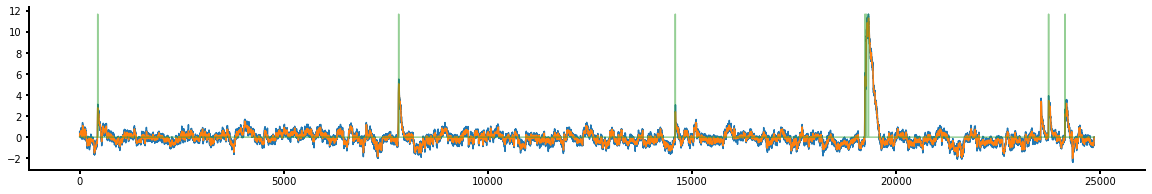

In [26]:
f,ax = plt.subplots(1,1,figsize=(20,3))
ax.plot(the_trace_mtx[:,0])
ax.plot(signal.medfilt(the_trace_mtx[:,0],9))
ax.plot(the_raster_isx_mtx[:,0]*max(the_trace_mtx[:,0]), alpha = .5)
twoaxis(ax)
plt.show()


In [27]:
peak_mtx = the_raster_isx_mtx * the_trace_mtx
print(np.shape(peak_mtx))

(24862, 47)


In [28]:
#z_peak_mtx = stats.zscore(peak_mtx,axis=0)
z_peak_mtx = the_raster_isx_mtx * z_trace_mtx
#z_peak_mtx -= np.min(z_peak_mtx, axis = 0)

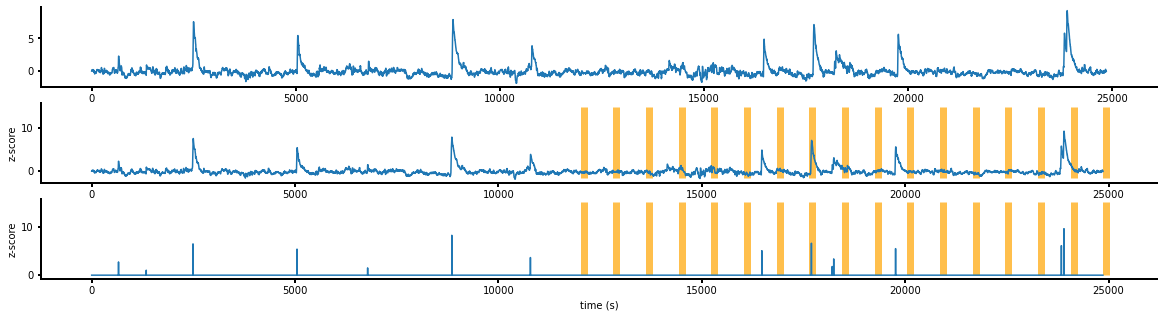

In [29]:
cellnum = 2

f,ax = plt.subplots(3,1,figsize=(20,5))
ax[0].plot(signal.medfilt(the_trace_mtx[:,cellnum], 7))
twoaxis(ax[0])
ax[1].plot(signal.medfilt(z_trace_mtx[:,cellnum],7))
#ax[1].vlines(np.asarray(social[3:]) - control_len, ymin=-1, ymax= 15, color='crimson')
ax[1].vlines(pulse_onsets[:] * fs + 90,ymin=-1.5, ymax= 15, color='orange', alpha = .7, linewidth=7)
#ax[1].vlines(pulse_onsets * fs , ymin=-1.5, ymax= 15, color='red', alpha = .7)
ax[1].set_ylabel('z-score')
twoaxis(ax[1])
#ax[2].plot(np.cumsum(z_trace_mtx[:,1]))
ax[2].plot(z_peak_mtx[:,cellnum])
ax[2].vlines(pulse_onsets[:] * fs + 90 , ymin=0, ymax= 15, color='orange', alpha=.7, linewidth = 7)
ax[2].set_ylabel('z-score')
ax[2].set_xlabel('time (s)')
twoaxis(ax[2])

plt.show()

In [30]:
print(len(pulse_onsets))
print(len(pulse_offsets))

17
16


In [31]:
pulse_len = int(fs * (pulse_offsets[0] - pulse_onsets[0]))
pre_win = int(20 * fs)
post_win = int(pre_win + pulse_len)

print(pulse_len / fs)

10.042161089053884


In [32]:
z_thresh = .5

data_mtx = z_trace_mtx[:,:25]
#data_mtx = ((data_mtx > z_thresh) * data_mtx) + ((data_mtx < z_thresh) + z_thresh )


print(np.nanmin(data_mtx))
print(np.shape(data_mtx))

-4.423701565401489
(24862, 25)


In [33]:
data_mtx_2 = data_mtx.copy()

In [34]:
print(np.shape(data_mtx_1))
print(np.shape(data_mtx_2))

(24690, 25)
(24862, 25)


In [36]:
combined_data = np.concatenate((data_mtx_1[:11000,:], data_mtx_2[:11000,:]), axis = 1).copy()

In [37]:
combined_data.shape

(11000, 50)

In [ ]:
aligned_mtx_1 = aligned_mtx.copy()

(25, 15, 1001)


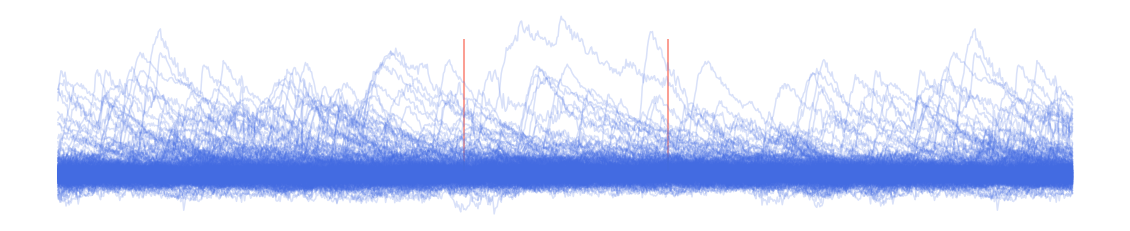

In [38]:
# align each cell's activity:

trigs = [int(i * fs) for i in pulse_onsets[:15]] # indices of trigger events

aligned_mtx = np.zeros((data_mtx.shape[1], len(trigs), pre_win + post_win ))
stat_mtx = np.zeros((data_mtx.shape[1], len(trigs)))
print(aligned_mtx.shape)

f,ax = plt.subplots(1,1,figsize = (20,4))


for ci, c in enumerate(data_mtx.transpose()): # each cell
    for ti, t in enumerate(trigs): # each trigger event
        start_t = max([0, t - pre_win])
        stop_t = min([len(c), t + post_win])
        spliced_trace = c[start_t : stop_t]
        aligned_mtx[ci,ti] = spliced_trace
        
        pulse_thresholded = spliced_trace[400:600][spliced_trace[400:600] > z_thresh]
        pre_thresholded = spliced_trace[0:400][spliced_trace[0:400] > z_thresh]
        if(len(pulse_thresholded)==0):
            pulse_thresholded = 1e-6
        if(len(pre_thresholded) == 0):
            pre_thresholded = 1e-6
        #the_stat = (np.nansum(spliced_trace[400:600]) / 200) / max(1e-6,(np.nansum(spliced_trace[:400]) / 400))
        the_stat = (np.nanmedian(spliced_trace[400:600])) / (np.nanmedian(spliced_trace[:400]))
        #the_stat = (np.nanmean(pre_thresholded) / np.nanmean(pulse_thresholded))
        stat_mtx[ci,ti] = the_stat

        ax.plot(spliced_trace, color='royalblue', alpha = .2)
ax.vlines([pre_win, pre_win + pulse_len], ymin = 0, ymax = 10, color='salmon')
#ax.set_xlim(400 - 10, 400 + 10)
ax.axis('off')       
plt.show()


In [ ]:
print(np.shape(aligned_mtx))
print(np.shape(aligned_mtx_1))

In [39]:
combined_aligned_mtx = np.concatenate((aligned_mtx,aligned_mtx_1), axis = 0).copy()
print(combined_aligned_mtx.shape)

(50, 15, 1001)


In [20]:
aligned_mtx_1 = aligned_mtx.copy()

In [49]:
aligned_mtx = combined_aligned_mtx.copy()

-3.6203449305247615
4.338798494581111
-1.1984489262331728


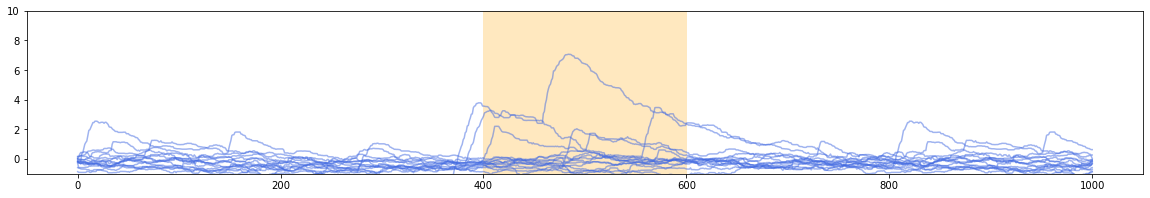

(50, 15, 1001)


In [50]:
cellnum = 8

print(np.nansum(aligned_mtx[cellnum,:,:400]) / 400)
print(np.nansum(aligned_mtx[cellnum,:,400:600]) / 200)
print((np.nansum(aligned_mtx[cellnum,:,400:600]) / 200) / (np.nansum(aligned_mtx[cellnum,:,:400]) / 400) )

f,ax = plt.subplots(1,1,figsize = (20,3))
for i in aligned_mtx[cellnum]:
    ax.plot(signal.medfilt(i, 7),alpha=.5, color='royalblue')

#ax.vlines([pre_win, pre_win + pulse_len], ymin = 0, ymax = 10, color='salmon')
ax.hlines(5, xmin = pre_win, xmax=pre_win + pulse_len, color='orange', alpha=.25, linewidth = 250)
ax.set_ylim(-1,10)
#ax.axis('off')
plt.show()
print(np.shape(aligned_mtx))

In [ ]:
print(stat_mtx.shape)
print(np.mean(stat_mtx,axis=1).shape)
print(stat_mtx[0],'\n')
print(np.nanmedian(np.nanmedian(stat_mtx, axis=1)))



f,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(np.ones((len(stat_mtx),1)), np.nanmedian(stat_mtx, axis=1), 'o', alpha = .25)
ax[0].hlines(1, xmin=.98, xmax = 1.02, color='salmon', alpha=.5)
ax[0].scatter(1, np.median(np.nanmedian(stat_mtx, axis=1)), s = 500, marker='_', linewidth = 3)
ax[0].set_xlim(.98,1.02)
ax[0].set_ylim(0,2)
ax[1].plot(np.nanmedian(stat_mtx, axis=1),'-o')

for a in ax:
    twoaxis(a)
plt.show()

In [ ]:
print(pop_act_pre.shape)

In [ ]:
print(aligned_mtx.shape)
#pop_act_stim = (np.nanmean(aligned_mtx[:,:,400:600], axis = 2) / (200*fs))
#pop_act_pre = (np.nanmean(aligned_mtx[:,:,:400], axis = 2) / (400*fs))
#pop_act_pre[pop_act_pre==0] = 1e-6
#pop_act_stim[pop_act_stim==0] = 1e-6

#pop_act_stim_a = (np.nanmean(aligned_mtx[:,:,400:420], axis = 2) / (20*fs))
#pop_act_stim_a[pop_act_stim_a==0] = 1e-6
#pop_act_stim_b = (np.nanmean(aligned_mtx[:,:,420:460], axis = 2) / (40*fs))
#pop_act_stim_b[pop_act_stim_b==0] = 1e-6
#pop_act_stim_c = (np.nanmean(aligned_mtx[:,:,460:600], axis = 2) / (140*fs))
#pop_act_stim_c[pop_act_stim_c==0] = 1e-6

pop_act_stim = (np.nanmedian(aligned_mtx[:,:,400:600], axis = 2))
pop_act_pre = (np.nanmedian(aligned_mtx[:,:,:400], axis = 2))
pop_act_pre[pop_act_pre==0] = 1e-6
pop_act_stim[pop_act_stim==0] = 1e-6

pop_act_stim_a = (np.nanmedian(aligned_mtx[:,:,400:460], axis = 2))
pop_act_stim_a[pop_act_stim_a==0] = 1e-6
pop_act_stim_b = (np.nanmedian(aligned_mtx[:,:,460:520], axis = 2))
pop_act_stim_b[pop_act_stim_b==0] = 1e-6
pop_act_stim_c = (np.nanmedian(aligned_mtx[:,:,520:600], axis = 2))
pop_act_stim_c[pop_act_stim_c==0] = 1e-6



f,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.nanmedian(pop_act_pre,axis=1),'o-')
ax.plot(np.nanmedian(pop_act_stim,axis=1),'o-')
twoaxis(ax)
plt.show()

titles = ['full photostim', '0-3s\nphotostim', '3-6s\nphotostim', '6-10s\nphotostim']
f,ax = plt.subplots(1,4,figsize=(10,6), sharey=True)
for pre,stim in zip(np.nanmedian(pop_act_pre,axis=1), np.nanmedian(pop_act_stim,axis=1)):
    ax[0].plot([0,1],[pre,stim],'o-', color='royalblue', alpha=.25)
ax[0].plot([0,1],[np.median(pop_act_pre), np.median(pop_act_stim)],'o-', color='blue', alpha=.9, markersize=10)
ax[0].set_ylabel('mean trace z-score')

for pre,stim in zip(np.nanmedian(pop_act_pre,axis=1), np.nanmedian(pop_act_stim_a,axis=1)):
    ax[1].plot([0,1],[pre,stim],'o-', color='royalblue', alpha=.25)
ax[1].plot([0,1],[np.median(pop_act_pre), np.median(pop_act_stim_a)],'o-', color='blue', alpha=.9, markersize=10)

for pre,stim in zip(np.nanmedian(pop_act_pre,axis=1), np.nanmedian(pop_act_stim_b,axis=1)):
    ax[2].plot([0,1],[pre,stim],'o-', color='royalblue', alpha=.25)
ax[2].plot([0,1],[np.median(pop_act_pre), np.median(pop_act_stim_b)],'o-', color='blue', alpha=.9, markersize=10)
    
for pre,stim in zip(np.nanmedian(pop_act_pre,axis=1), np.nanmedian(pop_act_stim_c,axis=1)):
    ax[3].plot([0,1],[pre,stim],'o-', color='royalblue', alpha=.25)
ax[3].plot([0,1],[np.median(pop_act_pre), np.median(pop_act_stim_c)],'o-', color='blue', alpha=.9, markersize=10)

for a,t in zip(ax,titles):
    twoaxis(a)
    a.set_title(t)
    a.set_xlim(-.5,1.5)
    #a.set_ylim(-1,.5)
    a.set_xticks([0,1])
    a.set_xticklabels(['pre_pulse', 'pulse'])
plt.show()

In [ ]:
cellnum = 0

f,ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(abs(pop_act_stim[cellnum] / pop_act_pre[cellnum]), '-o')
ax.hlines(1, xmin = 0, xmax = 16, color='crimson')
ax.axis('off')

ax.set_ylim(0,5)
plt.show()

f,ax = plt.subplots(1,1,figsize = (20,3))
for i in aligned_mtx[cellnum]:
    ax.plot(i, color = 'royalblue', alpha=.2)
for i,j in zip(pop_act_pre[cellnum], pop_act_stim[cellnum]):
    ax.hlines(i, xmin = 0, xmax = 400, color='blue', alpha = .5)
    ax.hlines(j, xmin = 400, xmax = 600, color='blue', alpha = .5)

ax.vlines([pre_win, pre_win + pulse_len], ymin = 0, ymax = 10, color='salmon') 
ax.axis('off')

plt.show()


In [ ]:
print(np.mean(pop_act_stim/pop_act_pre,axis=1).shape )

f,ax = plt.subplots(1,1,figsize=(4,6), sharey=True)

ax.scatter(np.zeros_like(np.mean(pop_act_stim/pop_act_pre,axis=1)), np.mean(pop_act_stim/pop_act_pre,axis=1), 25, color='orange', alpha=.25)
ax.scatter(0, np.mean(np.mean(pop_act_stim/pop_act_pre,axis=1)), 100, color='orange')

ax.scatter(1+np.zeros_like(np.mean(pop_act_stim_a/pop_act_pre,axis=1)), np.mean(pop_act_stim_a/pop_act_pre,axis=1), 25, color='royalblue', alpha=.25)
ax.scatter(1, np.mean(np.mean(pop_act_stim_a/pop_act_pre,axis=1)), 100, color='royalblue')

ax.scatter(2+np.zeros_like(np.mean(pop_act_stim_b/pop_act_pre,axis=1)), np.mean(pop_act_stim_b/pop_act_pre,axis=1), 25, color='royalblue', alpha=.25)
ax.scatter(2, np.mean(np.mean(pop_act_stim_b/pop_act_pre,axis=1)), 100, color='royalblue')

ax.scatter(3+np.zeros_like(np.mean(pop_act_stim_c/pop_act_pre,axis=1)), np.mean(pop_act_stim_c/pop_act_pre,axis=1), 25, color='royalblue', alpha=.25)
ax.scatter(3, np.mean(np.mean(pop_act_stim_c/pop_act_pre,axis=1)), 100, color='royalblue')

# horizontal lines for mean and SD: 
#ax.hlines([np.percentile(np.mean(pop_act_stim/pop_act_pre,axis=1),95), np.percentile(np.mean(pop_act_stim/pop_act_pre,axis=1),5)], xmin=-1, xmax=4, color='orange', alpha = .5)
#ax.hlines(np.std(np.mean(pop_act_stim/pop_act_pre,axis=1)), xmin=-1, xmax=4, color='orange', alpha = .85)


ax.set_ylabel('weighted event rate ratio (stim / pre)')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(titles, rotation = 335, horizontalalignment = 'left')
ax.grid('on', alpha=.5)

twoaxis(ax)

plt.show()

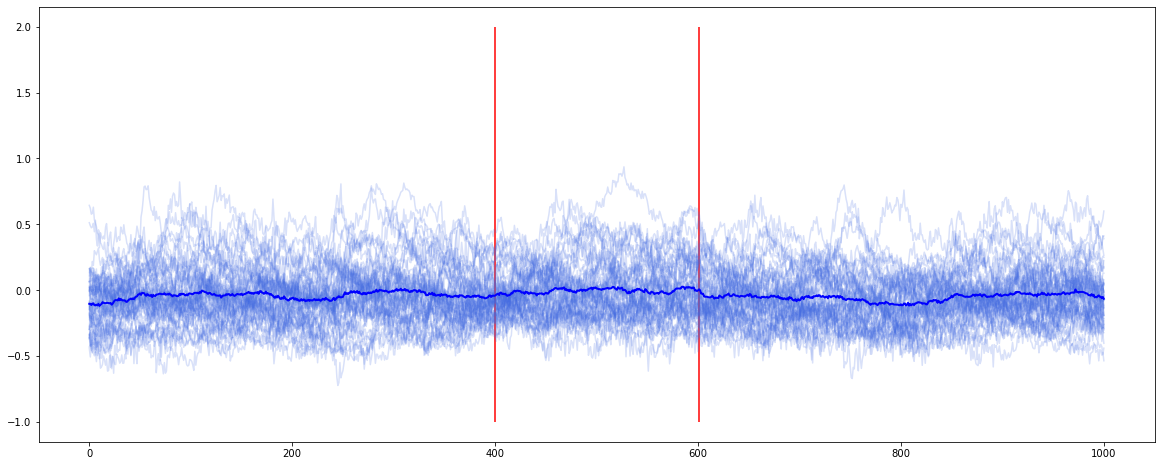

In [51]:
np.shape(np.mean(aligned_mtx, axis = 1))

f,ax  = plt.subplots(1, 1, figsize = (20,8))

for i in np.mean(aligned_mtx, axis = 1):
    ax.plot(i, color = 'royalblue', alpha = .2)

ax.plot(np.nanmean(np.nanmean(aligned_mtx, axis = 1), axis = 0), color='blue', linewidth = 2)
ax.vlines([pre_win, pre_win + pulse_len ] , ymin = -1, ymax = 2, color='red')
#ax.set_ylim(-.1, .1)
#ax.axis('off')
plt.show()

In [305]:
p_marker = np.argwhere(modulation_p_dist < .05).flatten()

(50, 1001)


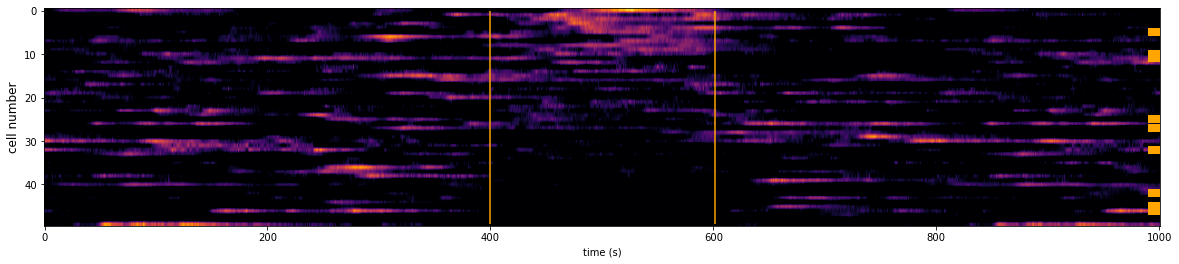

In [325]:
print(np.shape(np.mean(aligned_mtx, axis = 1)))

t_vect = np.linspace(-20, 50, aligned_mtx.shape[2])



f,ax = plt.subplots(1, 1, figsize = (20,4))
sort_key = np.argsort(np.max(np.mean(aligned_mtx, axis = 1)[:,400:600], axis=1) )[::-1]

ax.imshow(np.mean(aligned_mtx, axis = 1)[sort_key], cmap = 'inferno', aspect = 'auto', origin = 'upper',vmin = 0, vmax = 1)
ax.vlines([pre_win, pre_win + pulse_len ] , ymin = 0, ymax = aligned_mtx.shape[0]-1, color='orange')
ax.hlines(p_marker+1, xmin = 990, xmax = 1000.5, color='orange', linewidth = 8)

ax.set_ylabel('cell number', fontsize=12)
ax.set_xlabel('time (s)')
plt.show()

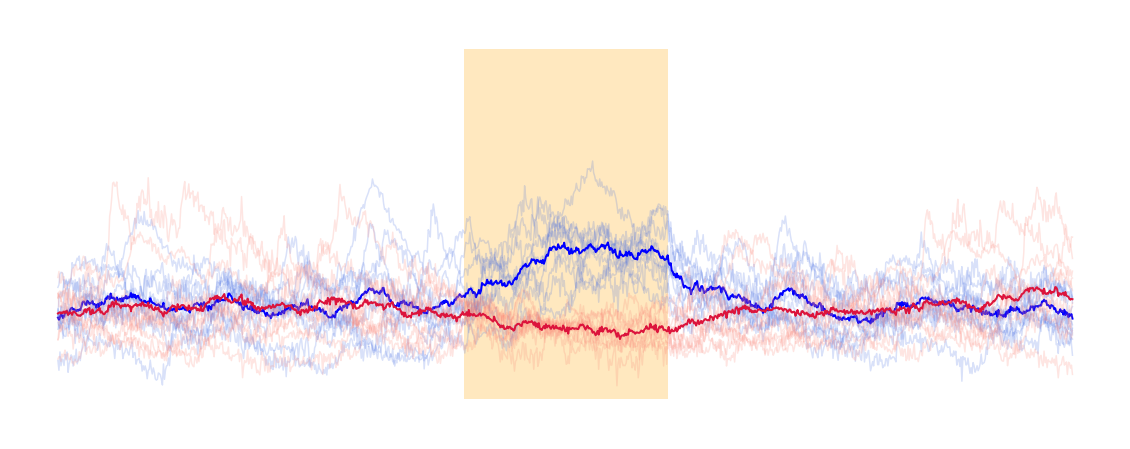

In [63]:
# plot top and bottom cells in modulation distribution:

f,ax  = plt.subplots(1, 1, figsize = (20,8))

for i in np.mean(aligned_mtx, axis = 1)[sort_key][:10]:
    ax.plot(i, color = 'royalblue', alpha = .2)

ax.plot(np.nanmean(np.nanmean(aligned_mtx, axis = 1)[sort_key][:10], axis = 0), color='blue', linewidth = 2)

for i in np.mean(aligned_mtx, axis = 1)[sort_key][-10:]:
    ax.plot(i, color = 'salmon', alpha = .2)

ax.plot(np.nanmean(np.nanmean(aligned_mtx, axis = 1)[sort_key][-10:], axis = 0), color='crimson', linewidth = 2)


#ax.vlines([pre_win, pre_win + pulse_len ] , ymin = -1, ymax = 2, color='red')
ax.hlines(.5, xmin = pre_win, xmax = pre_win + pulse_len , color='orange', linewidth=350, alpha = .25)
ax.set_ylim(-1, 2)
twoaxis(ax)
ax.axis('off')
plt.show()

### analyze pre --> stim modulation

In [ ]:
print(aligned_mtx.shape)

In [67]:
stat_mtx = np.zeros((aligned_mtx.shape[0], aligned_mtx.shape[1]))

for ci, cell in enumerate(aligned_mtx):
    for ti, trace in enumerate(cell):
        #print(trace.shape)
        #trace -= min(trace)
        the_stat = np.nanmean( (trace[405:600]) + np.min(trace)) / np.nanmean( (trace[:400] + np.min(trace)) )
        stat_mtx[ci][ti] = the_stat
    

In [65]:
stat_mtx.shape

(50, 15)

In [276]:
print(modulation_p_dist)
minmax = MinMaxScaler()
scaled_p = minmax.fit_transform(modulation_p_dist.reshape(-1,1)).flatten()

[0.35855883 0.39590287 0.40129758 0.25017716 0.03258479 0.25304242
 0.38172981 0.17595253 0.05010795 0.02542268 0.01392676 0.20996312
 0.30337277 0.48755907 0.33278229 0.30781287 0.36041304 0.20073292
 0.24284303 0.21070956 0.10191642 0.1885048  0.41145553 0.2011108
 0.01602672 0.1614312  0.         0.47540016 0.07660251 0.17073538
 0.13122016 0.04157225 0.33353902 0.18590696 0.09180999 0.22659426
 0.20023175 0.44188663 0.39078768 0.48062612 0.45484332 0.002
 0.31955888 0.25353966 0.01293818 0.04558009 0.40471699 0.33065368
 0.05333686 0.06074914]


In [278]:
1-scaled_p

array([0.26458381, 0.18798993, 0.1769252 , 0.48687824, 0.93316749,
       0.4810015 , 0.21705936, 0.63911547, 0.89722691, 0.94785724,
       0.97143574, 0.56935859, 0.37777228, 0.        , 0.31745237,
       0.36866547, 0.26078076, 0.58829005, 0.5019208 , 0.56782763,
       0.790966  , 0.61337034, 0.15609091, 0.58751501, 0.96712865,
       0.6688992 , 1.        , 0.02493833, 0.84288568, 0.64981601,
       0.73086305, 0.91473393, 0.31590028, 0.61869859, 0.81169464,
       0.53524758, 0.58931797, 0.0936757 , 0.19848137, 0.01421971,
       0.06710109, 0.99589793, 0.34457403, 0.47998165, 0.97346335,
       0.90651371, 0.16991187, 0.32181822, 0.89060432, 0.87540148])

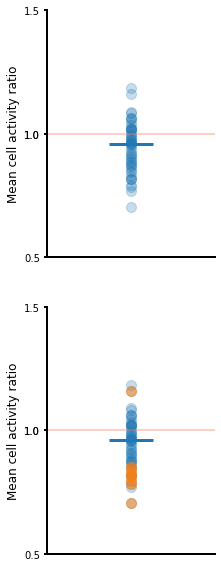

0.9595599759548147
Ttest_1sampResult(statistic=-3.765359098931399, pvalue=0.0004460046453729787)


In [326]:
cmap = plt.get_cmap('tab10')

f,ax = plt.subplots(2, 1, figsize=(3,10))
ax[0].scatter(np.ones_like( np.nanmedian(stat_mtx, axis=1)), np.nanmedian(stat_mtx, axis=1), s=100, color = cmap(0), alpha = .25)
ax[0].hlines(1, xmin=.98, xmax = 1.02, color='salmon', alpha=.5)
ax[0].scatter(1, np.median(np.nanmedian(stat_mtx, axis=1)), s = 2000, marker='_', linewidth = 3, color=cmap(0) )
ax[0].set_xlim(.99,1.01)
ax[0].set_ylim(.5,1.5)
ax[0].set_yticks([.5,1,1,1.5])
ax[0].set_xticks([])
ax[0].set_ylabel('Mean cell activity ratio', fontsize=12)
#ax[0].hlines((np.percentile(shuff_dist,1), np.percentile(shuff_dist,99)), xmin=.98, xmax = 1.02, color='salmon', alpha = .75)



                 
ax[1].scatter(np.ones_like( np.nanmedian(stat_mtx, axis=1)), np.nanmedian(stat_mtx, axis=1), s=100, color = cmap(0), alpha=.25)
ax[1].scatter(np.ones_like( np.nanmedian(stat_mtx, axis=1)[modulation_p_dist < .05]), np.nanmedian(stat_mtx, axis=1)[modulation_p_dist < .05], s=100, color = cmap(1), alpha=.5)
ax[1].hlines(1, xmin=.98, xmax = 1.02, color='salmon', alpha=.5)
ax[1].scatter(1, np.median(np.nanmedian(stat_mtx, axis=1)), s = 2000, marker='_', linewidth = 3, color=cmap(0))
ax[1].set_xlim(.99,1.01)
ax[1].set_ylim(.5,1.5)
ax[1].set_yticks([.5,1,1,1.5])
ax[1].set_xticks([])
ax[1].set_ylabel('Mean cell activity ratio', fontsize=12)


for a in ax:
    twoaxis(a)

plt.show()

print(np.median(np.nanmedian(stat_mtx, axis=1)))
print(stats.ttest_1samp(np.nanmedian(stat_mtx, axis=1), popmean=1))

## time-shuffled null comparisons:

In [ ]:
print(len(combined_data))
print(pulse_len)

In [86]:
# align on random points and generate confidence interval:

t_range = [pre_win + 1, len(combined_data) - (pulse_len*4)]
num_i = 1000

shuff_mtx = np.zeros((combined_data.shape[1], num_i, pre_win + post_win) )
shuff_stat_mtx = np.zeros((combined_data.shape[1], num_i))
rng = np.random.default_rng()


for ci, c in enumerate(combined_data.transpose()): # each cell
    for s in range(shuff_mtx.shape[1]): # each shuffle
        trigs = rng.integers(low = t_range[0], high = t_range[1], size = len(pulse_onsets))
        temp_mtx = np.zeros((len(trigs), pre_win + post_win))
        temp_stat_mtx = np.zeros((len(trigs), 1))
        for ti, t in enumerate(trigs): # each alignment point:
            start_t = max([0, t - pre_win])
            stop_t = min([len(c), t + post_win])
            spliced_trace = c[start_t : stop_t]
            #spliced_trace += np.nanmin(spliced_trace)
            #print(spliced_trace.shape)
            temp_mtx[ti] = spliced_trace
            
            the_stat = np.nanmean( (spliced_trace[405:600]) + np.min(spliced_trace)) / np.nanmean((spliced_trace[:400] + np.min(spliced_trace)) )
            #the_stat = np.nansum(c[t : t + pulse_len]) / max([1e-6, np.nansum(c[start_t : t])]) 
            temp_stat_mtx[ti] = the_stat
            
        shuff_mtx[ci][s] = np.median(temp_mtx, axis = 0)
        shuff_stat_mtx[ci,s] = np.median(temp_stat_mtx)
            

print(shuff_mtx.shape)


(50, 1000, 1001)


(50, 1000, 1001)
(50, 1000)
(50, 15, 1001)


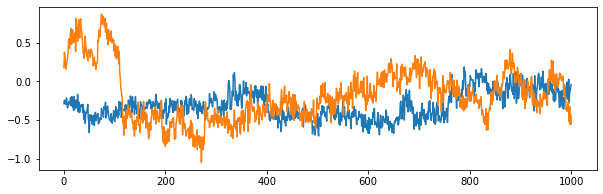

[-0.14986726 -0.44183107 -0.26156882 ...  0.04366154 -0.00691258
 -0.17773828]


In [87]:
print(shuff_mtx.shape)
print(shuff_stat_mtx.shape)
print(aligned_mtx.shape)

f,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(shuff_mtx[8][10])
ax.plot(aligned_mtx[8][0])

plt.show()

print(shuff_mtx[0][0])


In [80]:
print(shuff_stat_mtx.shape)

(50, 1000)


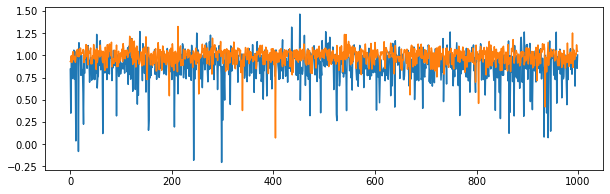

In [88]:
f,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(shuff_stat_mtx[1])
ax.plot(shuff_stat_mtx[10])

plt.show()

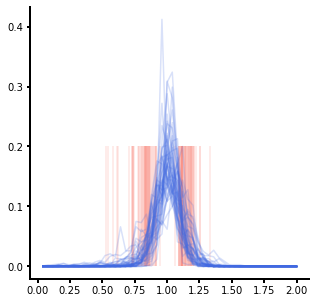

In [94]:
shuff_confs = []
for cell in shuff_stat_mtx:
    shuff_confs.append((np.percentile(cell,5), np.percentile(cell,95)))


f,ax = plt.subplots(1,1,figsize=(5,5))

for i in shuff_stat_mtx:
    h,hbins = np.histogram(i, bins = 50, range = (0,2))
    ax.plot(hbins[1:], h/sum(h), color='royalblue', alpha=.2)
    ax.vlines(((np.percentile(i,5), np.percentile(i,95))), ymin=0, ymax = .2, color='salmon', alpha=.2)
twoaxis(ax)

plt.show()

In [95]:
num_i = 1000

shuff_dist = []

for i in range(num_i):
    stat_vect = []
    for cell in shuff_stat_mtx:
        stat_vect.append(np.median(np.random.choice(cell, size=16)) )
    shuff_dist.append(np.median(stat_vect))

In [119]:
print(np.shape(shuff_dist))
print(shuff_stat_mtx.shape)
print(stat_mtx.shape)

(1000,)
(50, 1000)
(50, 15)


### cell-by-cell modulation significance test:

0.3809999999999999
0.23224999999999962


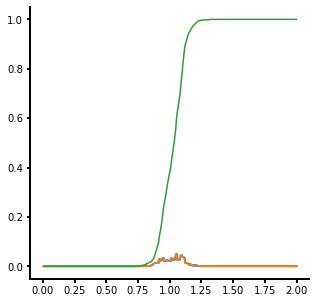

In [251]:
h,hbins = np.histogram(shuff_stat_mtx[0], bins = 250, range = (0,2))
hdist = stats.rv_histogram((h, hbins) )

pdf = hdist.pdf(hbins) / sum(hdist.pdf(hbins))

print(hdist.cdf(1))
print(min((hdist.cdf(.95), 1-hdist.cdf(.95))) )

f,ax = plt.subplots(1,1,figsize=(5,5 ))
ax.step(hbins[1:], h/sum(h))
#ax.plot(hbins[1:], hdist.pdf(hbins[1:]))
ax.plot(hbins,pdf)
ax.plot(hbins[1:], hdist.cdf(hbins[1:]))

twoaxis(ax)
plt.show()

In [257]:
#np.nanmedian(stat_mtx, axis=1)
modulation_p_dist = []

for cell_stat, cell_shuff in zip(stat_mtx, shuff_stat_mtx):
    h,hbins = np.histogram(cell_shuff, bins = 250, range = (0,2))
    hdist = stats.rv_histogram((h, hbins) )
    modulation_p_dist.append(min((hdist.cdf(np.median(cell_stat)), 1-hdist.cdf(np.median(cell_stat)))) )
    
    
modulation_p_dist = np.asarray(modulation_p_dist)

In [258]:
print(len(np.argwhere(modulation_p_dist < .05)))

9


In [ ]:
print(stat_mtx.shape)
print(shuff_stat_mtx.shape)


f,ax = plt.subplots(1,1,figsize = (4,6))
ax.plot(np.ones((len(stat_mtx),1)), np.mean(stat_mtx, axis = 1), 'o', color='royalblue', alpha = .25)
v = ax.violinplot(np.mean(stat_mtx, axis=1), positions = [1], showextrema=False, showmedians = True)

ax.plot(np.ones((len(shuff_stat_mtx),1)) + 1, np.mean(shuff_stat_mtx, axis = 1), 'o', color='orange', alpha = .25)
v = ax.violinplot(np.mean(shuff_stat_mtx, axis=1), positions = [2], showextrema=False, showmedians = True)
twoaxis(ax)
#ax.set_ylim(0, 500)
plt.show()

In [ ]:
print(shuff_stat_mtx.shape)

In [ ]:
print(np.shape(np.percentile(shuff_mtx, 95,axis = 1)))

In [ ]:
print(np.nanmin(np.mean(shuff_mtx, axis = 1)))
print(np.nanmin(np.mean(aligned_mtx, axis = 1)))
print(np.nanmax(np.mean(shuff_mtx, axis = 1)))
print(np.nanmax(np.mean(aligned_mtx, axis = 1)))

In [ ]:
print(np.shape(np.mean(shuff_mtx, axis = 1)))

f,ax = plt.subplots(2,2, figsize = (20,8))
ax[0][0].imshow(np.percentile(shuff_mtx, 99, axis = 1), cmap = 'inferno', aspect = 'auto', origin = 'upper', vmin = 0, vmax = 3)
ax[1][0].imshow(np.mean(shuff_mtx, axis = 1), cmap = 'inferno', aspect = 'auto', origin = 'upper', vmin = 0, vmax = 3)
#ax.imshow(shuff_mtx[10], cmap = 'inferno', aspect = 'auto', interpolation = 'hamming', origin = 'upper')
ax[0][0].vlines([pre_win, pre_win + pulse_len ] , ymin = 0, ymax = 49, color='red')
ax[1][0].vlines([pre_win, pre_win + pulse_len ] , ymin = 0, ymax = 49, color='red')

ax[0][1].imshow(np.mean(aligned_mtx, axis = 1) - np.percentile(shuff_mtx, 99, axis = 1), cmap = 'inferno', aspect = 'auto', origin = 'upper', vmin = 0, vmax = 2)
ax[1][1].imshow(np.mean(aligned_mtx, axis = 1) - np.mean(shuff_mtx, axis = 1), cmap = 'inferno', aspect = 'auto', origin = 'upper', vmin = 0, vmax = 2)
ax[0][1].vlines([pre_win, pre_win + pulse_len ] , ymin = 0, ymax = 49, color='red')
ax[1][1].vlines([pre_win, pre_win + pulse_len ] , ymin = 0, ymax = 49, color='red')
plt.show()